In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time
import simulation_functions as sfs

np.random.seed(42)

<module 'simulation_functions' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/simulation_functions.py'>

In [6]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bouttypes= ma.array(f['bout_types'], dtype=int)
# stims = ma.array(f['stims'])
# ecs = ma.array(f['eye_convergence'])

##shapes are n_fish, max_n_bouts,dim of variable

bouttypes_allcond= ma.array(f['bout_types'])
stims_allcond = ma.array(f['stims'])
ecs_allcond = ma.array(f['eye_convergence'])
ecs_st_allcond = ma.array(f['eye_convergence_state'])
time_Bout_allcond = ma.array(f['times_bouts']) #raw times bouts

#shapes are n_fish, max_n_bouts,dim of variable
X_head_allcond = ma.array(f['head_pos'])
phi_smooth_allcond = ma.array(f['orientation_smooth'])
speeds_head_allcond = ma.array(f['speed_head'])
f.close()

In [7]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked
X_head_allcond[X_head_allcond == 0] = ma.masked
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked
bouttypes_allcond[bouttypes_allcond == 15] = ma.masked
ecs_allcond[ecs_allcond == 100] = ma.masked

In [12]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

In [13]:
print(len(condition_labels))

14


In [14]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [3]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()


In [4]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish[labels_fish == to_mask] = ma.masked

In [8]:
print(lengths.shape,lengths_all.shape)

(463,) (463,)


In [9]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [15]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [16]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)

In [17]:
# Load eigenfunctions

eigfunctions = np.load(path_to_filtered_data + 'eigfs_n1200.npy')
phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]

# Uncomment to discover eigenfunctions and eigenvalues from ensemble transition matrix. 
# The estimation of eigenvalues is done through ARPACK, which is stochastic in nature. 
# This can result in the eigenvectors flipping sign. 
# If that happens, you can change the random seed in op_calc.sorted_spectrum()

# from scipy.sparse import diags,identity,coo_matrix, csr_matrix
# P_ensemble = csr_matrix(P_ensemble)

# import msmtools.estimation as msm_estimation
# lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
# R = op_calc.get_reversible_transition_matrix(P_ensemble)
# eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123) 
# sorted_indices = np.argsort(eigvals.real)[::-1]
# eigvals = eigvals[sorted_indices][1:].real
# eigvals[np.abs(eigvals-1)<1e-12] = np.nan
# eigvals[eigvals<1e-12] = np.nan
# t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
# eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
# eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
# eigfunctions_traj[final_labels.mask] = ma.masked

3


In [18]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [19]:
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

dtrajs_fish_phi1 = distorted_fish[:,:,0]
dtrajs_fish_phi2 = distorted_fish[:,:,1]

In [20]:
kms = np.load('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/cg2_labels.npy')
kmeans_labels = kms
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

## Prey Capture hunting rates

In [52]:
cond = 9

pc_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
# pc_recs = np.arange(193,442)
print(pc_recs)

maxL = np.max(lengths_all[pc_recs])
lengths = lengths_all[pc_recs]

[193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257]


In [53]:
time_Bout = time_Bout_allcond[pc_recs,:maxL,:]
ecs_pc = ecs_allcond[pc_recs,:maxL]

In [54]:
print(time_Bout.shape)
print(ecs_pc.shape)

(65, 3068, 2)
(65, 3068)


In [55]:
tmspace_clusters = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy')[pc_recs]

In [56]:
print(len(tmspace_clusters))
print(np.unique(tmspace_clusters))

65
[0 2 3 4 5 6]


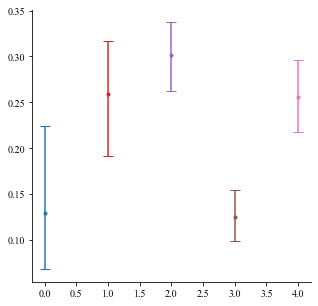

In [58]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

m_pc = []
cil_pc = []
ciu_pc = []

for i,clus in enumerate([0,3,4,5,6]):
    hunt_num = []
    for cf in np.where(tmspace_clusters == clus)[0]:
        if ((time_Bout[cf,lengths[cf]-1,1] - time_Bout[cf,0,0])/700/60) > 5:
            hunt_num.append(len(np.where(ecs_pc[cf] == 2)[0])/lengths[cf])
    
#     print(hunt_num)
    m, cil, ciu = stats.bootstrap(hunt_num,n_times=1000)
    
    ax.errorbar(i,m, [m-cil,ciu-m], fmt='.',capsize=5,color='C{}'.format(clus))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [59]:
cond = 13

pc_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
# pc_recs = np.arange(193,442)
print(pc_recs)

maxL = np.max(lengths_all[pc_recs])
lengths = lengths_all[pc_recs]

[387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442]


In [60]:
time_Bout = time_Bout_allcond[pc_recs,:maxL,:]
ecs_pc = ecs_allcond[pc_recs,:maxL]

In [61]:
print(time_Bout.shape)
print(ecs_pc.shape)

(56, 2305, 2)
(56, 2305)


In [62]:
tmspace_clusters = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy')[pc_recs]

In [63]:
print(len(tmspace_clusters))
print(np.unique(tmspace_clusters))

56
[0 5 6]


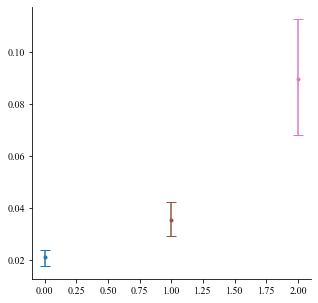

In [64]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

m_pc = []
cil_pc = []
ciu_pc = []

for i,clus in enumerate([0,5,6]):
    hunt_num = []
    for cf in np.where(tmspace_clusters == clus)[0]:
        if ((time_Bout[cf,lengths[cf]-1,1] - time_Bout[cf,0,0])/700/60) > 5:
            hunt_num.append(len(np.where(ecs_pc[cf] == 2)[0])/lengths[cf])
    
#     print(hunt_num)
    m, cil, ciu = stats.bootstrap(hunt_num,n_times=1000)
    
    ax.errorbar(i,m, [m-cil,ciu-m], fmt='.',capsize=5,color='C{}'.format(clus))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)